# Wishart distribution tests
    
See https://github.com/scipy/scipy/blob/master/scipy/stats/_multivariate.py

Note: The mean of the Wishart distribution $W_p(\Sigma, \nu)$
is $\nu \Sigma$, not $\Sigma$ as stated in eq. (17) of TJK13.

In [2]:
import scipy.stats._multivariate as mv

## The following is an alternative definition of a Wishart random variable.

In [3]:
W = mv.wishart_gen()

In [4]:
df = 3; scale = [[1,0], [0,2]];
df

3

In [5]:
W.rvs(df, scale)

array([[ 2.20448364,  1.72988444],
       [ 1.72988444,  6.35840882]])

## Covariance and precision matrix.

In [10]:
n_D = 10

In [11]:
sig2 = 1

In [12]:
cov     = np.diag([sig2 for i in range(n_D)])
cov_inv = np.diag([1/sig2 for i in range(n_D)])

In [13]:
a_n_S = []
a_trN_est = []
a_trN_m1_est = []
a_trN_m1_est2 = []

for n_S in range(n_D+5, 50, 1):
    W = mv.wishart(df=n_S-1, scale=cov)
    
    # The mean of a Wishart distribution in 1D is nu. Therefore,
    # we need to divide by nu=n_S-1 (?)
    cov_est = W.rvs() / (n_S-1)
    
    ## Covariance matrix
    
    # The division by n_D is to get the normalised trace.
    trN_est = np.trace(cov_est) / n_D
            
    ## Precision matrix 1: numerically invert covariance
    cov_est_inv = np.linalg.inv(cov_est)
    trN_m1_est = np.trace(cov_est_inv) / n_D
        
    ## Precision matrix 2: sample from inverse Wishart distribution
    Wm1 = mv.invwishart(df=n_S-1, scale=cov_inv)
    cov_est_inv2 = Wm1.rvs()
    trN_m1_est2 = np.trace(cov_est_inv2) * n_S / n_D
    
    # The bias of the inverse is 1/alpha. In other words, multiply with alpha
    # for unbiased estimate
    alpha = (n_S - n_D - 2) / (n_S - 1)
    #print(n_S, trN_est, sig2, '   ', trN_m1_est, trN_m1_est2, 1 / alpha / sig2, 1/sig2)
    
    a_n_S.append(n_S)
    a_trN_est.append(trN_est)
    a_trN_m1_est.append(trN_m1_est)
    a_trN_m1_est2.append(trN_m1_est2)

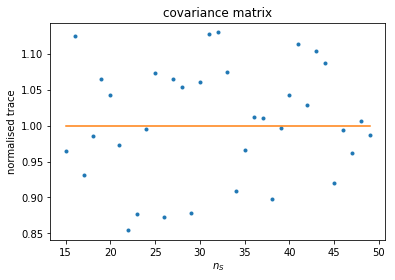

In [14]:
plt.plot(a_n_S, a_trN_est, '.', a_n_S, [sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('covariance matrix')
plt.show()

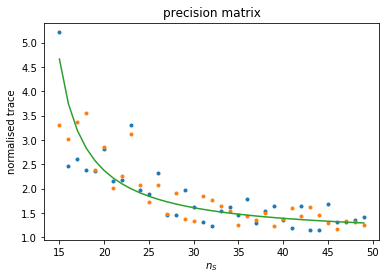

In [15]:
plt.plot(a_n_S, a_trN_m1_est, '.', \
         a_n_S, a_trN_m1_est2, '.', \
         a_n_S, [(n_S - 1) / (n_S - n_D - 2) / sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('precision matrix')
plt.show()

## Plotting the Wishart distribution.

In [16]:
from scipy.stats import multivariate_normal

In [17]:
def get_cov_ML(cov, size):

    n_D = cov.shape[0]
    y2 = multivariate_normal.rvs(mean=np.zeros(n_D), cov=cov, size=size)
    # y2[:,j] = realisations for j-th data entry
    # y2[i,:] = data vector for i-th realisation

    # Calculate covariance matrix via np
    cov_est = np.cov(y2, rowvar=False)
    return cov_est


In [18]:
n_S = 20
n_R = 1000
i=0
j=0
# Correction of scale matrix (true covariance) to match ML cov estimate
cov_c = cov / (n_S - 1)

In [19]:
W = mv.wishart(df=n_S-1, scale=cov_c)
wij = []
for r in range(n_R):
    w = W.rvs()
    wij.append(w[i][j])

In [20]:
cij = []
for r in range(n_R):
    c = get_cov_ML(cov, n_S) 
    cij.append(c[i][j])

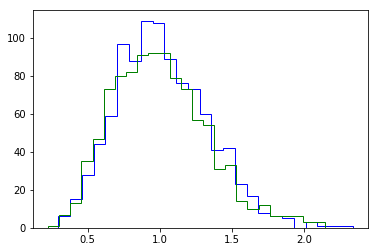

In [21]:
if n_S > n_D:
    plt.hist(wij, bins=25, histtype='step', color='b')
plt.hist(cij, bins=25, histtype='step', color='g')
plt.show()

### Comparing mean and variance

The mean of the Wishart distribution ${\cal W}_p\left(S, \nu\right)$ with $p \times p$ scale matrix $S$ and degrees of freedom $\nu$ is

$\langle \hat S \rangle = \nu S$.

The mean of the inverse Wishart distribution ${\cal W}_p^{-1}\left(T, \nu\right)$ is

$\langle \hat T \rangle = (\nu - p - 1)^{-1} T$.

The covariance matrix $\hat C$ as estimated from $n_{\rm s} = \nu + 1$ Gaussian random fields with true covariance matrix $C$ follows the distribution ${\cal W}_p(S = \nu^{-1} \, C, \nu)$.

The inverse of this estimated covariance, $\hat \psi = {\hat C}^{-1}$, has a biased mean,

$\alpha^{-1} C^{-1} = (\nu - p - 1)^{-1} \nu \, C^{-1}$.

It follows the inverse Wishart distribution ${\cal W}_p^{-1}\left( T = \nu \, C^{-1}, \nu\right)$.


The variance of the Wishart distribution is (on the diagonal)

$\langle (\Delta \hat S_{ii})^2 \rangle = 2 \nu S_{ii}^2 = 2 \nu^{-1} \, C_{ii}^2.$


The variance of the inverse Wishart distribution is (on the diagonal)

$(\Delta \hat T_{ii})^2 = 2 (\nu - p -3)^{-1} (\nu - p - 1)^{-2} \, T_{ii}^2 = 2 (\nu - p -3)^{-1} (\nu - p - 1)^{-2} \nu^2 \, C_{ii}^{-2} = 2 (\nu - p -3)^{-1} \, \alpha^{-2} \, C_{ii}^{-2} = 2 \beta \, \alpha^{-2} \, (\nu - p) \, C_{ii}^{-2},$

where in the last step we use

$\beta = (\nu - p)^{-1} (\nu - p -3)^{-1},$

as defined in the paper (eq. 17).

This result corresponds to eq. (16) in the paper, with an additional $\alpha^{-2}$ that is added in (23).


In [22]:
mean_true = cov[i][j] / (n_S - 1) * (n_S - 1)
var_true   = (cov[i][j]**2 + cov[i][i]*cov[j][j]) / (n_S - 1)
if n_S > n_D:
    mean_wij  = np.mean(wij)
    var_wij   = np.var(wij)
else:
    mean_wij = 'undef'
    var_wij  = 'undef'
mean_cij  = np.mean(cij)
var_cij   = np.var(cij)
print(mean_true, mean_wij, mean_cij)
print(var_true, var_wij, var_cij)

1.0 1.01860879725 1.00180321525
0.105263157895 0.100602332331 0.107237649586


## Plot of mean and variance as function of n_S

In [23]:
n_S_arr = []
for n_S in range(2, n_D, 1):
    n_S_arr.append(n_S)
for n_S in range(n_D, 2*n_D, 2):
    n_S_arr.append(n_S)
for n_S in range(2*n_D, 5*n_D, 10):
    n_S_arr.append(n_S)
for n_S in range(5*n_D, 20*n_D, 20):
    n_S_arr.append(n_S)

### Numerical mean and variance

In [24]:
var_c   = []
var_w   = []
mask_w  = []
for n_S in n_S_arr:
    
    cij = []
    for r in range(n_R):
        c = get_cov_ML(cov, n_S) 
        cij.append(c[i][j])
        
    wij = []    
    if n_S > n_D:
        W = mv.wishart(df=n_S-1, scale=cov / (n_S - 1))
        for r in range(n_R):
            w = W.rvs()
            wij.append(w[i][j])
            
    var_c.append(np.var(cij))
    
    if n_S > n_D:
        var_w.append(np.var(wij))
        mask_w.append(0)
    else:
        var_w.append(-1)
        mask_w.append(1)
        
var_mw  = np.ma.masked_array(var_w, mask=mask_w)

### Numerical variance of inverse covariance

In [25]:
var_inv_c   = []
var_inv_w   = []
mask_c = []
mask_w  = []
for n_S in n_S_arr:
    
    if n_S > n_D:
        cij = []
        for r in range(n_R):
            c = get_cov_ML(cov, n_S)
            # No de-biasing here
            psi = np.linalg.inv(c)
            cij.append(psi[i][j])

        var_inv_c.append(np.var(cij))
        mask_c.append(0)
    else:
        var_inv_c.append(-1)
        mask_c.append(1)
        
    #df = n_S - n_D - 2
    df = n_S - 1
    if df > n_D:
        wij = []
        W = mv.invwishart(df=df, scale=cov_inv * (n_S - 1))
        for r in range(n_R):
            w = W.rvs()
            wij.append(w[i][j])
    
        var_inv_w.append(np.var(wij))
        mask_w.append(0)  
    else:
        var_inv_w.append(-1)
        mask_w.append(1)
        
var_inv_mc  = np.ma.masked_array(var_inv_c, mask=mask_c)
var_inv_mw  = np.ma.masked_array(var_inv_w, mask=mask_w)
print(var_inv_mc[12:16])
print(var_inv_mw[12:16])

[2.9704714209543344 1.9839717997959074 0.3243276652749006
 0.14084542415938364]
[3.1537175322788054 1.8553913418997483 0.3328655144184826
 0.14557846755165543]


### True variance

In [26]:
var_tr  = []
n_S_fine = np.arange(n_S_arr[0], n_S_arr[-1], len(n_S_arr)/100.0)
for n_S in n_S_fine:
    var_tr.append(1/(n_S - 1) * (cov[i][j]**2 + cov[i][i]*cov[j][j]))

### True variance of inverse covariance

In [27]:
var_inv_tr  = []
mask = []
for n_S in n_S_fine:
    if n_S > n_D + 4:
        var_inv_tr.append(2 / (n_S - n_D - 2)**2 / (n_S - n_D - 4) * (n_S - 1)**2 * cov_inv[i][i]**2)
        mask.append(0)
    else:
        var_inv_tr.append(-1)
        mask.append(1)
var_inv_trw  = np.ma.masked_array(var_inv_tr, mask=mask)

/Users/mkilbing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


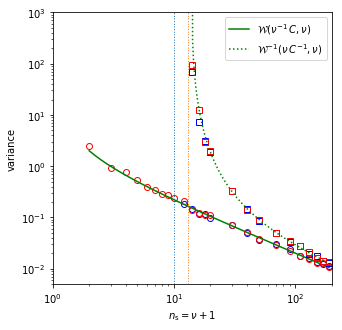

In [42]:
plt.figure(figsize=(5,5))
plt.plot(n_S_arr, var_mw, 'bo', mfc='none')
plt.plot(n_S_arr, var_c, 'ro', mfc='none')
plt.plot(n_S_fine, var_tr, 'g', label='${\\cal W}(\\nu^{-1} \, C, \\nu)$')

plt.plot(n_S_arr, var_inv_mw, 'bs', mfc='none')
plt.plot(n_S_arr, var_inv_mc, 'rs', mfc='none')
plt.plot(n_S_fine, var_inv_tr, 'g:', label='${\\cal W}^{-1}(\\nu \, C^{-1}, \\nu)$')
plt.xlabel('$n_{\\rm s} = \\nu + 1$')
plt.ylabel('variance')
ax = plt.subplot(1, 1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(1, 20*n_D)
plt.ylim(5e-3, 1e3)
ylim = plt.ylim()
plt.legend(loc='best')
plt.plot([n_D, n_D], ylim, ':', linewidth=1)
plt.plot([n_D+3, n_D+3], ylim, ':', linewidth=1)
plt.axes().set_aspect('auto')
plt.savefig('W.pdf')
plt.show()

In [783]:
n_S_fine

array([   2.  ,    2.24,    2.48,    2.72,    2.96,    3.2 ,    3.44,
          3.68,    3.92,    4.16,    4.4 ,    4.64,    4.88,    5.12,
          5.36,    5.6 ,    5.84,    6.08,    6.32,    6.56,    6.8 ,
          7.04,    7.28,    7.52,    7.76,    8.  ,    8.24,    8.48,
          8.72,    8.96,    9.2 ,    9.44,    9.68,    9.92,   10.16,
         10.4 ,   10.64,   10.88,   11.12,   11.36,   11.6 ,   11.84,
         12.08,   12.32,   12.56,   12.8 ,   13.04,   13.28,   13.52,
         13.76,   14.  ,   14.24,   14.48,   14.72,   14.96,   15.2 ,
         15.44,   15.68,   15.92,   16.16,   16.4 ,   16.64,   16.88,
         17.12,   17.36,   17.6 ,   17.84,   18.08,   18.32,   18.56,
         18.8 ,   19.04,   19.28,   19.52,   19.76,   20.  ,   20.24,
         20.48,   20.72,   20.96,   21.2 ,   21.44,   21.68,   21.92,
         22.16,   22.4 ,   22.64,   22.88,   23.12,   23.36,   23.6 ,
         23.84,   24.08,   24.32,   24.56,   24.8 ,   25.04,   25.28,
         25.52,   25